## Simple tests for grabbing frames

OpenCV has a nice wrapper around webcams. Let's test it there to get the simplest code that we would need in our library.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

/usr/local/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [3]:
import numpy as np
np.set_printoptions(precision=2, suppress=True)
# define plots to be inserted interactively
import matplotlib.pyplot as plt
import time
import cv2
cv2.__version__

/usr/local/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


'3.1.0'

In [3]:
class Source:
    def __init__(self, w=640, h=480):
        self.h, self.w = h, w
        import cv2
        self.cap = cv2.VideoCapture(0)
        self.cap.set(cv2.CAP_PROP_FRAME_WIDTH, self.w)
        self.cap.set(cv2.CAP_PROP_FRAME_HEIGHT, self.h)
      
    def grab(self):
        # grab a frame
        returned, cam_data = self.cap.read()
        data = cam_data.reshape((self.h, self.w, 3))
        return data
    
    def close(self):
        self.cap.release()
        del self.cap

start = time.time()
cam = Source()
cam.close()
print('Time to start and stop the camera = ',  time.time() - start , '(s)')


Time to start and stop the camera =  2.778756856918335 (s)


This is implemented in the ``LeCheapEyeTracker``class:

In [4]:
from openRetina import PhotoReceptor

cam = PhotoReceptor()
cam.close()


In [5]:
for DOWNSCALE in [1, 2, 4, 8, 16]:
    start = time.time()
    cam = PhotoReceptor(DOWNSCALE=DOWNSCALE)
    cam.close()
    print('DOWNSCALE = ', DOWNSCALE, 'startup= ',  time.time() - start , '(s)')

DOWNSCALE =  1 startup=  1.2368531227111816 (s)
DOWNSCALE =  2 startup=  2.399998903274536 (s)
DOWNSCALE =  4 startup=  2.4666459560394287 (s)
DOWNSCALE =  8 startup=  2.503915786743164 (s)
DOWNSCALE =  16 startup=  2.881314992904663 (s)


Time to start, grab 2 frames and stop =  3.065593957901001 (s)
(360, 640, 3) 0 255


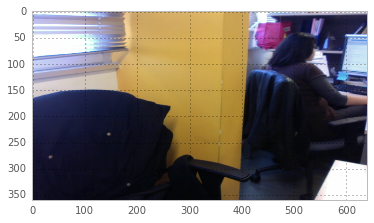

In [6]:
start = time.time()
cam = PhotoReceptor(DOWNSCALE=2)
img = cam.grab()
img = cam.grab()
cam.close()
print('Time to start, grab 2 frames and stop = ',  time.time() - start , '(s)')
print(img.shape, img.min(), img.max())
_ = plt.imshow(img)

In [7]:
for DOWNSCALE in [1, 2, 4, 8, 16]:
    cam = PhotoReceptor(DOWNSCALE=DOWNSCALE)
    start = time.time()
    img = cam.grab()
    img = cam.grab()
    cam.close()
    print('DOWNSCALE = ', DOWNSCALE, 'grab time= ',  time.time() - start , '(s)')

DOWNSCALE =  1 grab time=  0.7451260089874268 (s)
DOWNSCALE =  2 grab time=  0.5222020149230957 (s)
DOWNSCALE =  4 grab time=  0.5115559101104736 (s)
DOWNSCALE =  8 grab time=  0.4271240234375 (s)
DOWNSCALE =  16 grab time=  1.0183649063110352 (s)


## how fast do we grab frames?

In [8]:
N = 100
ctime = np.zeros(N)
start = time.time()
cam = PhotoReceptor()
for i in range(N):
    img = cam.grab()
    ctime[i] = time.time() - start
cam.close()

FPS :  19.4203604619


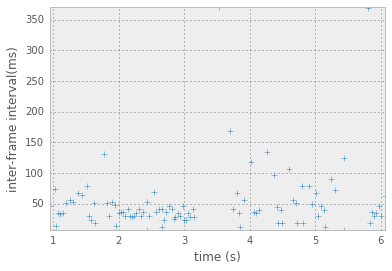

In [9]:
plt.plot(ctime[1:], np.diff(ctime)*1000, '+')
plt.xlabel('time (s)')
plt.ylabel('inter-frame interval(ms)')
_ = plt.axis('tight')
print ('FPS : ',  N/(ctime[-1]-ctime[0]))

## closing the camera

In [10]:
cam = PhotoReceptor()
cam.close()

## threaded mode

Following the documentation @ http://docs.opencv.org/modules/highgui/doc/reading_and_writing_images_and_video.html?highlight=imread it is easy to run parallel captures :

In [1]:
from multiprocessing.pool import ThreadPool
from collections import deque
import cv2
import time

class StatValue:
    def __init__(self, smooth_coef = 0.5):
        self.value = None
        self.smooth_coef = smooth_coef
    def update(self, v):
        if self.value is None:
            self.value = v
        else:
            c = self.smooth_coef
            self.value = c * self.value + (1.0-c) * v

def clock():
    return cv2.getTickCount() / cv2.getTickFrequency()

def draw_str(dst, target, s):
    x, y = target
    cv2.putText(dst, s, (x+1, y+1), cv2.FONT_HERSHEY_PLAIN, 1.0, (0, 0, 0), thickness = 2, lineType=cv2.LINE_AA)
    cv2.putText(dst, s, (x, y), cv2.FONT_HERSHEY_PLAIN, 1.0, (255, 255, 255), lineType=cv2.LINE_AA)


class ThreadSource:
    def __init__(self, w=640, h=480, threads=True):
        self.h, self.w = h, w
        import cv2
        self.cap = cv2.VideoCapture(0)
        self.cap.set(cv2.CAP_PROP_FRAME_WIDTH, self.w)
        self.cap.set(cv2.CAP_PROP_FRAME_HEIGHT, self.h)

        if threads:
            self.threadn = cv2.getNumberOfCPUs()
        else:
            self.threadn = 1
        self.pool = ThreadPool(processes = self.threadn)
        self.pending = deque()

        self.latency = StatValue()
        self.frame_interval = StatValue()
        self.last_frame_time = clock()        
        self.display = False
        self.ctime = []
        self.N = 0

    def process_frame(self, frame, t0):
        # some intensive computation...
        frame = cv2.medianBlur(frame, 19)
        time.sleep(.1)
        frame = cv2.medianBlur(frame, 19)
        return frame, t0

    def run(self, T=10):
        start = clock()
        while clock()-start <10.:
            while len(self.pending) > 0 and self.pending[0].ready():
                res, t0 = self.pending.popleft().get()
                self.latency.update(clock() - t0)
                if self.display:
                    draw_str(res, (20, 40), "latency        :  %.1f ms" % (self.latency.value*1000))
                    draw_str(res, (20, 60), "frame interval :  %.1f ms" % (self.frame_interval.value*1000))
                    cv2.imshow('Webcam video', res)
                self.ctime.append(time.time() - start)
                self.N += 1
            if len(self.pending) < self.threadn:
                ret, frame = self.cap.read()
                t = clock()
                self.frame_interval.update(t - self.last_frame_time)
                self.last_frame_time = t
                task = self.pool.apply_async(self.process_frame, (frame.copy(), t))
                self.pending.append(task)
            ch = 0xFF & cv2.waitKey(1)
            if ch == 27:
                self.close()
    
    def close(self):
        self.cap.release()
        if self.display: cv2.destroyAllWindows()

start = time.time()
cam = ThreadSource()
ctime = cam.run()
cam.close()
start_nothreads = time.time()
cam_nothreads = ThreadSource(threads=False)
ctime = cam_nothreads.run()
cam_nothreads.close()

In [4]:
plt.plot(np.array(cam.ctime)[1:]-cam.ctime[0], np.diff(np.array(cam.ctime))*1000, 'b+')
plt.plot(np.array(cam_nothreads.ctime)[1:]-cam_nothreads.ctime[0], np.diff(np.array(cam_nothreads.ctime))*1000, 'rx')
plt.xlabel('time (s)')
plt.ylabel('inter-frame interval(ms)')
_ = plt.axis('tight')
print ('FPS threaded: ',  cam.N/(cam.ctime[-1]-cam.ctime[0]))
print ('FPS one thread: ',  cam_nothreads.N/(cam_nothreads.ctime[-1]-cam_nothreads.ctime[0]))

FPS threaded:  14.881503517843884
FPS one thread:  4.693083332183334


In practice, we will see nice improvments when the image processing pipeline is more consequent. This threaded mode is enabled by default.

##  creating a video for debugging

It may be sometimes useful to just read out some frames for debugging: move your eyes, not the head = we grab 42 frames. why 42? I recommend to not move the head (hold them in your hands) and to look at the led of your webcam. when it's lit, move your eyes evenly on the screen.

In [6]:
import os
import time
import cv2

N_frame = 42 # how much you want?
folder = '/tmp/debug' # where we do save the frames
try: 
    os.mkdir(folder)

    from openRetina import PhotoReceptor
    cam = PhotoReceptor()

    time.sleep(1.5)

    start = time.time()
    for i in range(N_frame):
        frame = cam.grab()
        t = time.time() - start   
        # https://docs.python.org/3.3/library/string.html#format-examples
        timestr = '{t:03.5f}'.format(t=t).replace('.', '_')
        fname = 'frame_{i}.png'.format(i=i)
        print(fname)
        cv2.imwrite(os.path.join(folder, fname), frame)
        time.sleep(0.3)

    cam.close()

except: 
    print('folder already existing (or 🐛🐛🐛)')
    pass


folder already existing (or 🐛🐛🐛)
